# Keywords-Anchor Texts Analysis
    by Loveme Felicilda
    

## Problem:

For the website: https://backlinko.com

we want to study:

(1) If the number of appearances of a certain word or phrase in the anchor texts of links to a page leads to a higher ranking position of that page in Google when searching for that keyword.

So if I create a lot of links with a certain keyword in the anchor text, will that lead to a higher ranking of my page for that keyword?


(2) The same kind of study, but for words and/or phrases in "surrounding text"


(3) A study of how many keywords that a page ranks for (in top10) are not present:
- in anchor text of incoming links;
- in surrounding text of incoming links
- in content of the page (optional, you'll have to scrape content of the pages on your own)

## Solution:

Took the following steps in solving the problem:

### Imports

In [1]:
import pandas as pd
import glob
import requests
from sklearn.externals import joblib as jl
import numpy as np
from scipy.stats.stats import spearmanr
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib

pd.set_option('display.max_columns', 50)
%matplotlib inline

### Data Extraction

#### Combine downloaded keywords csvs

In [ ]:
files = glob.glob("data/backlinko*.csv") 

header_saved = False
for filename in files:
    if not header_saved:
        keywords = pd.read_csv(filename, sep='\t', encoding='utf-16')
        header_saved = True
    else: keywords = keywords.append(pd.read_csv(filename, sep='\t', encoding='utf-16'), ignore_index=True)
        
jl.dump(keywords, 'data/keywords.jl', compress=1)

#### Extract Backlinks Data from API

In [ ]:
r = requests.get("http://apiv2.ahrefs.com?token=<removed token>&target=backlinko.com&limit=202110&output=json&from=backlinks&mode=subdomains" )

backlinks = r.json()['refpages']

backlinks = pd.DataFrame(r.json()['refpages'])

jl.dump(backlinks, 'data/backlinks.jl', compress=1)

### Load Extracted Data

In [2]:
keywords= jl.load('data/keywords.jl')

keywords.tail(3)

,#,Keyword,Position,Position History,Position History Date,Volume,URL,Traffic,Results,Last Update,Difficulty,CPC,Page URL inside
1876,44,best cost per action programs,10,NaN,NaN,10,https://backlinko.com/cpa-marketing,0.29,25900000,2017-09-20 19:56:34,31,0.9,NaN
1877,1,seo contents,10,9.0,2017-10-03 16:36:03,500,https://backlinko.com/seo-content,11.00,54300000,2017-10-19 23:31:06,40,12.0,NaN
1878,2,keyword first,9,NaN,NaN,50,https://backlinko.com/seo-content,1.50,183000000,2017-09-22 11:43:37,2,NaN,NaN


In [3]:
backlinks = jl.load('data/backlinks.jl')
backlinks.tail(2)

,ahrefs_rank,ahrefs_top,alt,anchor,domain_rating,encoding,first_origin,first_seen,http_code,ip_from,language,last_origin,last_visited,link_type,links_external,links_internal,nofollow,original,page_size,prev_visited,redirect,sitewide,text_post,text_pre,title,url_from,url_from_first_seen,url_to
119136,0,0,,skyscraper technique package,16,utf8,fresh,2016-01-15T03:50:38Z,200,216.58.206.225,,recrawl,2017-10-07T22:00:48Z,href,30,20,False,True,18665,2017-09-03T04:31:03Z,0,False,.,"To know more about it, checkout the whole",Free SEO Tips: 7 SEO Reasons The Skyscraper Te...,http://seospruce.blogspot.com/2014/12/skyscrap...,2016-01-15T03:50:04Z,http://www.backlinko.com/skyscraper-technique
119137,11,0,,Link Building Case Study: How I Increased My S...,64,utf8,fresh,2017-05-31T17:48:46Z,200,34.193.231.150,en,fresh,2017-05-31T17:48:46Z,href,21,126,True,True,50082,,0,False,,1) How to create amazing content -,Some serious thoughts to help me increase my w...,http://www.warriorforum.com/main-internet-mark...,2015-02-12T14:58:55Z,http://www.backlinko.com/skyscraper-technique


### Join anchor texts associated to pages in top 10

In [4]:
keywords_backlink = keywords[['Keyword', 'Position', 'URL']].merge(backlinks[['anchor', 'text_post', 'text_pre', 'url_from' ,'url_to']],
                                                                  how='left', left_on=['URL'], right_on=['url_to'])
keywords_backlink = keywords_backlink.drop_duplicates().reset_index(drop=True)

#### convert all strings to lowercase (for text matching)

In [5]:
for cols in keywords_backlink.columns:
    if cols.strip() != 'Position':
        keywords_backlink[cols] = keywords_backlink[cols].apply(lambda x: x.lower())

In [6]:
keywords_backlink.head()

,Keyword,Position,URL,anchor,text_post,text_pre,url_from,url_to
0,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,how to rank for any keyword,,,http://www.perthmetroseo.com.au/about/,https://backlinko.com/how-to-rank-for-any-keyword
1,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,how to rank for any keyword,,,http://www.perthmetroseo.com.au/belmont/,https://backlinko.com/how-to-rank-for-any-keyword
2,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,how to rank for any keyword,,,http://www.perthmetroseo.com.au/cannington/,https://backlinko.com/how-to-rank-for-any-keyword
3,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,how to rank for any keyword,,,http://www.perthmetroseo.com.au/kalamunda/,https://backlinko.com/how-to-rank-for-any-keyword
4,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,how to rank for any keyword,,,http://www.perthmetroseo.com.au/midland/,https://backlinko.com/how-to-rank-for-any-keyword


### Pre-processing:
   - extract keywords and backlinks data from ahref site following the instructions in the video
   - combine all keywords csv files together in 1 table (keywords table)
   - join keywords table with backlinks table, so that we might know what links and anchor texts leads to the pages on top 10
 

In [ ]:
# jl.dump(keywords_backlink, 'data/keywords_backlink.jl', compress=1)

### Get matching keywords and anchor texts

In [7]:
# keywords_backlink = jl.load('data/keywords_backlink.jl')
# match_anchor = keywords_backlink[keywords_backlink.apply(lambda x: x.Keyword in x.anchor, axis=1)].drop_duplicates()
# jl.dump(match_anchor, 'data/match_anchor.jl', compress=1)
match_anchor = jl.load('data/match_anchor.jl')
print('Number of keywords matched with anchor texts: {}'.format(len(match_anchor)))

Number of keywords matched with anchor texts: 55288


### Get the mean and median of matches per page rank

In [8]:
key_anchor = match_anchor.groupby(['Keyword'], as_index=False).agg({'Position': max, 'url_from': len})
pos_anchor_cnt = key_anchor.groupby('Position').agg({'url_from': [np.mean, np.median]})
pos_anchor_cnt.columns = pos_anchor_cnt.columns.set_levels(['anchor'], level=0)

### Plot occurrence of keywords in anchor texts

### Answer to (1) and (2):
#### Processing:
- get counts of keyword occurrence in the **anchor texts** and **surrounding texts** for the top 10 pages
- get mean and median counts of keyword occurrence in the **anchor texts** and **surrounding texts** for the top 10 pages
- correlate page rank and occurrence of keywords in anchor text and in surrounding texts using **spearman correation coefficient**

#### Findings:
- There is a **small negative correlation** between keywords occuring in the anchor texts and in the surrounding texts. <br>
     (note that higher rank means: lesser the rank number) 
- keywords occuring in the anchor texts and/or surrounding texts, <br>
     help boost the rank <br>
- keywords in anchor texts has ~15% more correlation to top pages compared to keywords in surrounding texts <br>
   this means, keywords placed in the anchor texts more likely would lead to higher rank <br>
   (but I really think that a good balance between placing keywords in anchor texts and surrounding texts would help raise the      page rank)
- Remember that **correlation is not causation**. There are other factors that affects page rank.

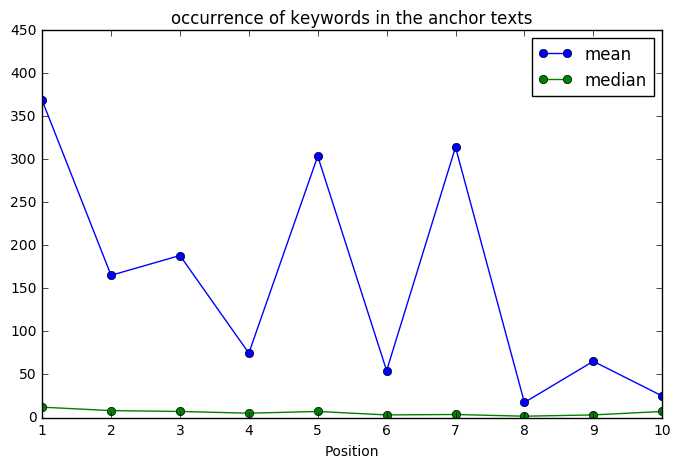

In [9]:
key_anchor_plt  = pos_anchor_cnt.plot(kind='line', title='occurrence of keywords in the anchor texts', marker='o',
                                    ylim=[0, 450], figsize=(8, 5))
key_anchor_plt = key_anchor_plt.legend(['mean', 'median'], loc='best')

### get matching keywords and surrounding texts

In [10]:
# match_surround = keywords_backlink[keywords_backlink.apply(lambda x: (x.Keyword in x.text_post) 
#                                                            | (x.Keyword in x.text_pre), axis=1)].drop_duplicates()
# jl.dump(match_surround, 'data/match_surround.jl', compress=1)
match_surround = jl.load('data/match_surround.jl')
print('Number of keyword matched with surrounding texts: {}'.format(len(match_surround)))

Number of keyword matched with surrounding texts: 28100


### get mean and median for matches per page rank

In [11]:
key_surround = match_surround.groupby(['Keyword'], as_index=False).agg({'Position': max, 'url_from': len})
pos_surround_cnt = key_surround.groupby('Position').agg({'url_from': [np.mean, np.median]})
pos_surround_cnt.columns = pos_surround_cnt.columns.set_levels(['surrounding'], level=0)

### Plot occurrence of keywords in surrounding text

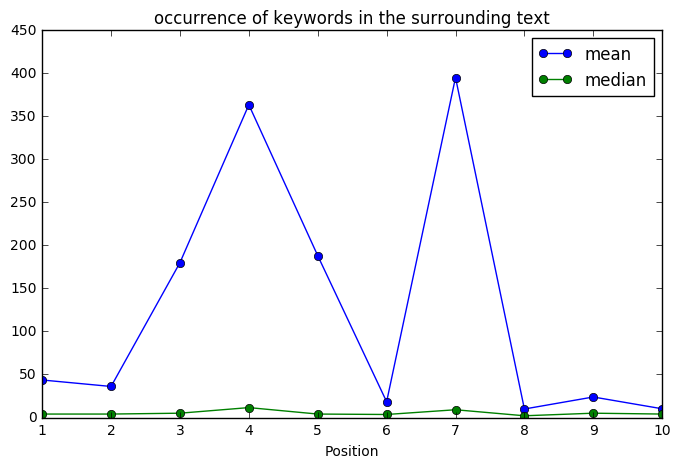

In [12]:
key_surround_plt = pos_surround_cnt.plot(kind='line', title='occurrence of keywords in the surrounding text',
                                         marker='o', ylim=[0, 450], figsize=(8, 5))
key_surround_plt = key_surround_plt.legend(['mean', 'median'], loc='best')

#### combine results

In [13]:
anchor_surround_pos = pd.concat([pos_anchor_cnt, pos_surround_cnt], axis=1)

## Comparing keyword occurrence in anchor texts and surrounding texts

   - more keywords are found in anchor texts than in the surrounding texts in the top 3 pages 
   - for the succeeding page ranks, this does not hold true
   - there seem to be a slight correlation between page rank and number of keywords both in the anchor texts and surrounding texts
   - there must be some other factors that affects how page ranks
   - some things to consider: similarity/correlation between content of the page and content of the backlinks, domain rating of the backlink, occurrence of keywords in backlink URL

### Average number of keyword occurrence in anchor and surrounding texts

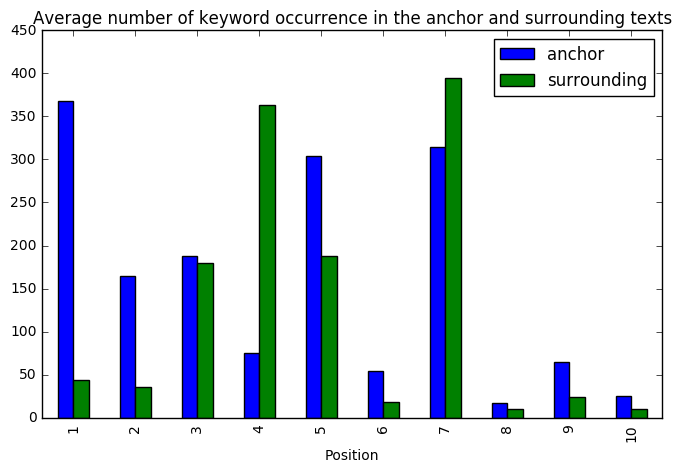

In [14]:
mean_pos = anchor_surround_pos.iloc[:, anchor_surround_pos.columns.get_level_values(1)=='mean']
mean_pos = mean_pos.plot(kind='bar', title='Average number of keyword occurrence in the anchor and surrounding texts',
                        ylim=[0, 450], figsize=(8, 5))
mean_pos = mean_pos.legend(['anchor','surrounding'])

### Median of keyword occurrence in anchor and surrounding texts

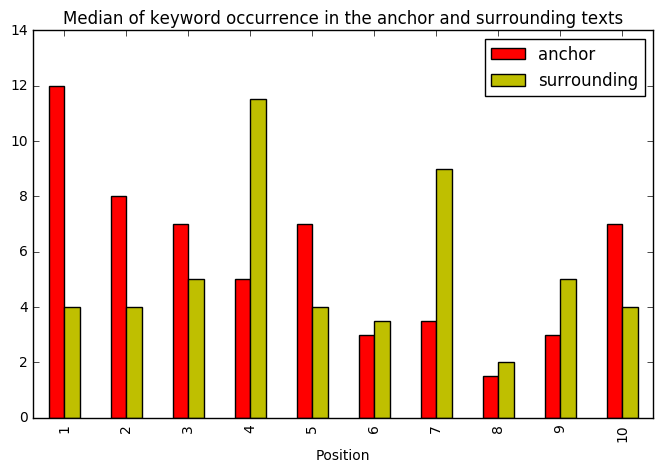

In [15]:
median_pos = anchor_surround_pos.iloc[:, anchor_surround_pos.columns.get_level_values(1)=='median']
median_pos = median_pos.plot(kind='bar', title='Median of keyword occurrence in the anchor and surrounding texts',
                            color=['r','y'], ylim=[0,14], figsize=(8, 5))
median_pos = median_pos.legend(['anchor','surrounding'])

### Spearman Correlation coefficients for keywords matching anchor texts and keywords matching surrounding texts

In [16]:
cor_table = pd.DataFrame({'correlation': [spearmanr(key_anchor.url_from, key_anchor.Position).correlation,
                 spearmanr(key_surround.url_from, key_surround.Position).correlation],
             }, index=['keywords in anchor texts', 'keywords in surrounding texts'])

In [17]:
cor_table

,correlation
keywords in anchor texts,-0.162982
keywords in surrounding texts,-0.014589


### Answer to (3):

#### Preprocessing:

- Get number of keywords in the top 10 not present in anchor texts, surrounding texts and in page content
- scrape the page (in top 10) content of those pages where keywords are not found in all in anchor texts, surrounding texts and in page content

### Keywords not present in anchor texts, surrounding texts and content of page in top 10

In [18]:
unmatch = keywords_backlink[(~keywords_backlink.index.isin(match_anchor.index)) &
                            (~keywords_backlink.index.isin(match_surround.index))]\
                            [['Keyword', 'Position', 'URL', 'url_from']].drop_duplicates()
print(len(unmatch))

2952148


In [19]:
unmatch.head()

,Keyword,Position,URL,url_from
0,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/about/
1,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/belmont/
2,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/cannington/
3,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/kalamunda/
4,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/midland/


### Get contents of pages

In [20]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True


def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return (u" ".join(t.strip() for t in visible_texts)).lower()

def extract_page_contents (urls):
    contents = []
    unreachable_urls = []
    for URL in urls:

        req = urllib.request.Request(URL,
                               headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/7046A194A'})

        try:
            with urllib.request.urlopen(req) as url:
                s = url.read()
                contents.append((text_from_html(s)))
        except urllib.error.URLError as e:
            unreachable_urls.append(URL)
        except urllib.request.ssl.CertificateError as c:
            unreachable_urls.append(URL)
            
    return contents, unreachable_urls

### get contents of pages in top 10

In [ ]:
page_contents, unreachable_urls = extract_page_contents(unmatch.URL.unique())

pg_content_df = pd.DataFrame({'page_content': page_contents,
                              'URL': unmatch.URL.unique()})

jl.dump(pg_content_df, 'data/pg_content_df.jl', compress=1)

In [ ]:
unreachable_urls

In [21]:
pg_content_df = jl.load('data/pg_content_df.jl')
pg_content_df.head()

,URL,page_content
0,https://backlinko.com/how-to-rank-for-any-keyword,op...
1,http://backlinko.com/increase-conversions,...
2,http://backlinko.com/about-backlinko,op...
3,https://backlinko.com/how-to-rank-youtube-videos,...
4,http://backlinko.com/seo-campaign,...


### Join contents to unmached keywords dataframe

In [22]:
unmatch = unmatch.merge(pg_content_df, on='URL', how='inner')
unmatch.head()

,Keyword,Position,URL,url_from,page_content
0,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/about/,op...
1,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/belmont/,op...
2,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/cannington/,op...
3,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/kalamunda/,op...
4,how to rank for keywords,7,https://backlinko.com/how-to-rank-for-any-keyword,http://www.perthmetroseo.com.au/midland/,op...


### Get keywords not in top 10 page contents

In [23]:
unmatch = unmatch[unmatch.apply(lambda x: x.Keyword in x.page_content, axis=1)].drop_duplicates()

In [24]:
len(unmatch)

232354

In [25]:
unmatch.head()

,Keyword,Position,URL,url_from,page_content
165,how to rank,6,https://backlinko.com/how-to-rank-for-any-keyword,http://digitalreview.co/how-to-write-sharable-...,op...
166,how to rank,6,https://backlinko.com/how-to-rank-for-any-keyword,https://1upmedia.com/25-creative-content-promo...,op...
167,how to rank,6,https://backlinko.com/how-to-rank-for-any-keyword,https://1upmedia.com/digital-philippines-2/,op...
168,how to rank,6,https://backlinko.com/how-to-rank-for-any-keyword,https://ahrefs.com/blog/skyscraper-technique/,op...
169,how to rank,6,https://backlinko.com/how-to-rank-for-any-keyword,https://bloggingio.com/internet-marketing-blogs/,op...


In [26]:
keywords_num_backlinks = unmatch.groupby(['Position', 'Keyword'],
                                         as_index=False, sort=False).agg({'url_from': ['count']}).sort_values(by=[('url_from',
                                                                                                                  'count')],
                                                                                                             ascending=False)
keywords_num_backlinks.head()

,Position,Keyword,url_from
,,,count
53,1,backlinko,12620
131,8,advanced link building,6950
130,8,link building techniques,6949
129,7,link building techniques,6949
127,5,link building campaign,6946


In [27]:
total_keywords = list(keywords.Keyword.drop_duplicates().values)
print('Total number of keywords in pages in top 10: {}'.format(len(total_keywords)))

Total number of keywords in pages in top 10: 1661


In [28]:
unmatched_keywords = list(keywords_num_backlinks['Keyword'].drop_duplicates().values)
print('Number of umatched keywords in anchor texts, surrounding texts and page (top 10) content:')
print(len(unmatched_keywords))

Number of umatched keywords in anchor texts, surrounding texts and page (top 10) content:
144


In [29]:
print('Here are the list:')

Here are the list:


In [30]:
unmatched_keywords

['backlinko',
 'advanced link building',
 'link building techniques',
 'link building campaign',
 'link building guide',
 'link building technique',
 'resource page link building',
 'black hat link building',
 'building links',
 'link building strategies',
 'google ranking factor',
 'brian dean',
 '200 factors',
 'google ranking factors',
 'google ranking',
 'google rank',
 'ranking youtube videos',
 'video keywords',
 'first page rankings',
 'ranking factors',
 'search engine ranking',
 'the skyscraper technique',
 'youtube seo',
 'on-page seo checklist',
 'on page',
 'backlinko.com',
 'seotools',
 'high pr backlinks',
 'get backlinks',
 'on page seo',
 'pr backlinks',
 'pr backlink',
 'skyscraper technique',
 'on-page seo',
 'free seo tool',
 'quickurl',
 'free seo',
 'best seo tool',
 'the best seo tool',
 'link building for seo',
 'keyword research guide',
 'keyword research for seo',
 'page seo',
 'easy link building',
 'how to get backlink',
 'resource pages',
 'how to get backli

In [31]:
print ("{0:.1f}% of all the keywords are not in anchor texts, surrounding texts and page content".format(len(unmatched_keywords)/len(total_keywords) * 100))

8.7% of all the keywords are not in anchor texts, surrounding texts and page content


####  For further research:


- scrape the content of the backlinks to those pages


- Do document similarity using **tfidf**/ **Latent Semantic Indexing** /
    **Latent Dirichlet Allocation**/ **word-to-vec** and etc. <br> then **cosine similarity**/
    **affinity propagation** and etc. between page content and backlink url content

## Attempt to do Additional stuff:

Willing to extend the research to this but scrapping those pages and storing them takes too much time and resource for my personal laptop ^_^

### get contents of backlinks

In [ ]:
backlinks_contents, unreachable_urls = extract_page_contents(unmatch.url_from.unique())

In [ ]:
bl_content_df = pd.DataFrame({'link_content': backlinks_contents,
                              'url_from': unmatch.url_from.unique()})
bl_content_df.head()

In [ ]:
jl.dump(bl_content_df, 'data/bl_content_df.jl', compress=1)